
#  Importar librerias y leer imagen


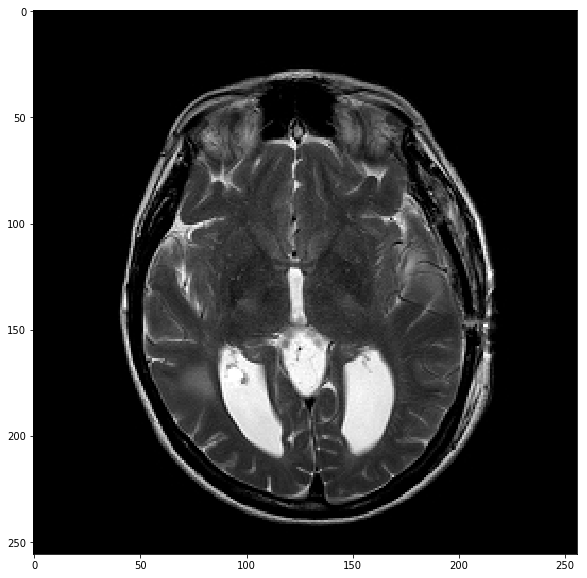

In [7]:

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import imageio
import cv2
import numpy as np
import math
from PIL import Image

import warnings
try:
    import pydicom as dicom
    
except ImportError:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        import dicom
        
plt.rcParams['figure.figsize'] = [10, 10]
ruta_imagen = "13.dcm"
imagen = imageio.imread(ruta_imagen)
imagencv2 = cv2.imread(ruta_imagen, 0)

plt.imshow(imagen,cmap='gray')
plt.show()



# Reduccion de ruido con filtro Gaussiano [1]


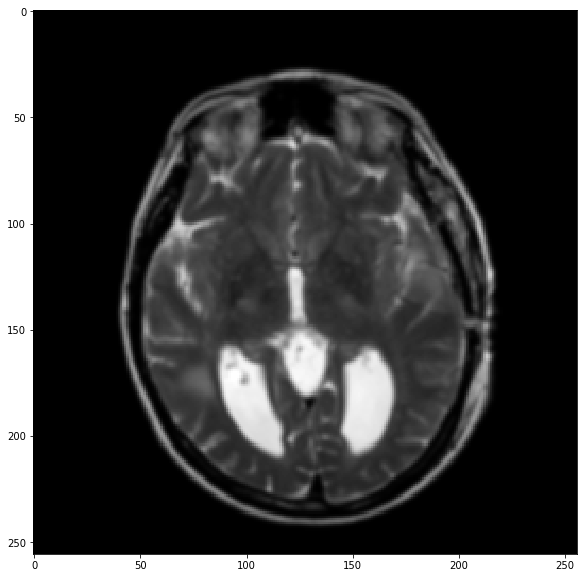

In [8]:
imagencv2 = cv2.GaussianBlur(imagencv2,(5,5),1)

plt.imshow(imagencv2,cmap='gray')
plt.show()


# Histograma y Otsu


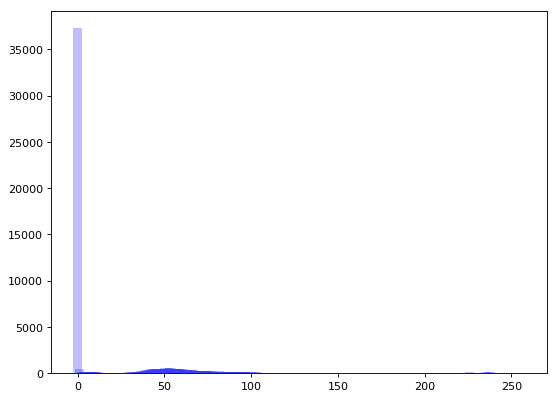

 
Valor del umbral calculado con el algoritmo de Otsu: 91
 


In [4]:
# -- -- -- -- -- -- Histograma -- -- -- -- -- -- #
def calcularHistograma(img):
   row, col,r = img.shape 
   y = np.zeros(256)
   for i in range(0,row):
      for j in range(0,col):
         y[img[i,j]] += 1
   x = np.arange(0,256)
   plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
   plt.bar(x, y, color='b', width=5, align='center', alpha=0.25)
   plt.show()
   return y

# -- -- -- -- -- -- -- Otsu -- -- -- -- -- -- -- #
def countPixel(h):
    cnt = 0
    for i in range(0, len(h)):
        if h[i]>0:
           cnt += h[i]
    return cnt

def wieght(s, e, h):
    w = 0
    for i in range(s, e):
        w += h[i]
    return w

def mean(s, e, h):
    m = 0
    w = wieght(s, e, h)
    for i in range(s, e):
        m += h[i] * i
    
    return m/float(w)

def variance(s, e, h):
    v = 0
    m = mean(s, e, h)
    w = wieght(s, e, h)
    for i in range(s, e):
        v += ((i - m) **2) * h[i]
    v /= w
    return v        

def threshold(h):
    
    varMax = float(0)
    threshold = 0
    cnt = countPixel(h)

    for i in range(1, len(h)):
        vb = variance(0, i, h)
        wb = wieght(0, i, h) / float(cnt)
        mb = mean(0, i, h)
        
        vf = variance(i, len(h), h)
        wf = wieght(i, len(h), h) / float(cnt)
        mf = mean(i, len(h), h)
        
        V2w = wb * (vb) + wf * (vf)
        V2b = wb * wf * (mb - mf)**2
                
        if not math.isnan(V2w):
            if V2b > varMax :
                varMax = V2b
                threshold = i
    
    return threshold

histograma = calcularHistograma(imagen)
threshold_value =  threshold(histograma)
print(' ')
print('Valor del umbral calculado con el algoritmo de Otsu:', threshold_value)
print(' ')


# Sobel [2]


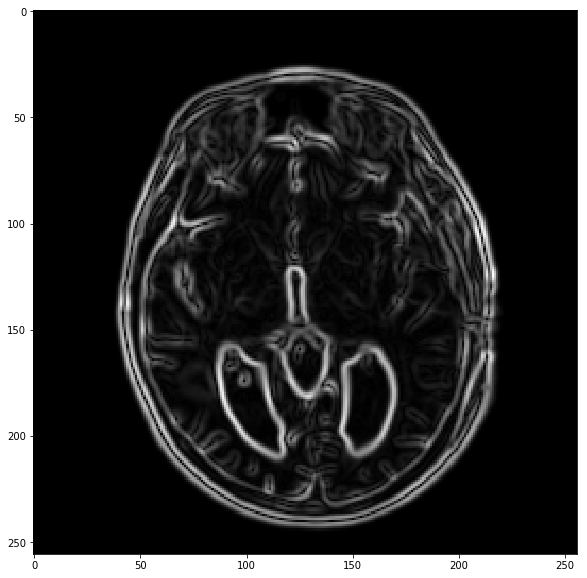

In [9]:
def conv(image, kernel):
    # Tamaño de la imagen
    image_h = image.shape[0]
    image_w = image.shape[1]

    # Tamaño del kernel
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]

    h = kernel_h//2 #integer
    w = kernel_w//2

    image_conv = np.zeros(image.shape) # Matriz de ceros del tamaño de la imagen

    for i in range(h, image_h-h):
        for j in range(w, image_w-w):
            sum=0

            for m in range(kernel_h):
                for n in range(kernel_w):
                    sum = (sum + kernel[m][n]*image[i-h+m][j-w+n])

            image_conv[i][j] = sum

    return image_conv


def norm(img1,img2):
    img_copy = np.zeros(img1.shape) #image with initial zero values
    for i in range(img1.shape[0]):
        for j in range(img1.shape[1]):
            q = (img1[i][j]**2 + img2[i][j]**2)**(1/2)
            img_copy[i][j] = q
            
    return img_copy

#------------------------------
kernel_x = np.zeros(shape=(3,3))
kernel_x[0,0] = -1
kernel_x[0,1] = 0
kernel_x[0,2] = 1
kernel_x[1,0] = -2
kernel_x[1,1] = 0
kernel_x[1,2] = 2
kernel_x[2,0] = -1
kernel_x[2,1] = 0
kernel_x[2,2] = 1
gx = conv(imagencv2, kernel_x)
#------------------------------
kernel_y = np.zeros(shape=(3,3))
kernel_y[0,0] = -1
kernel_y[0,1] = -2
kernel_y[0,2] = -1
kernel_y[1,0] = 0
kernel_y[1,1] = 0
kernel_y[1,2] = 0
kernel_y[2,0] = 1
kernel_y[2,1] = 2
kernel_y[2,2] = 1
gy = conv(imagencv2, kernel_y)
#------------------------------
#print("Aplicando Sobel...")
sobelImage = norm(gx, gy)

plt.imshow(sobelImage,cmap='gray')
plt.show()


# Local Binary Patterns [3]


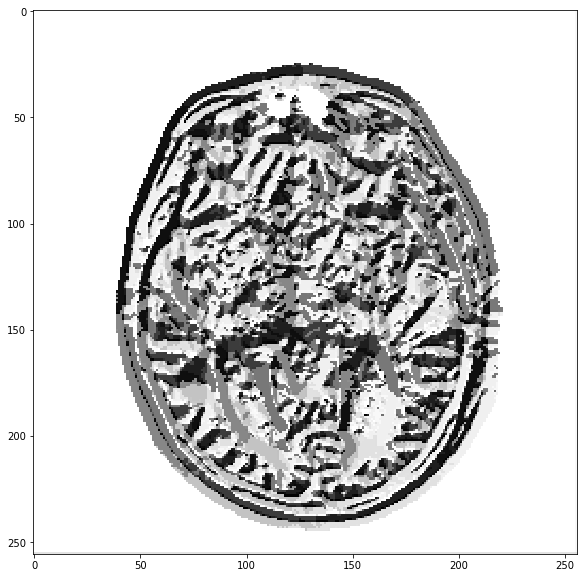

In [10]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    '''
     64 | 128 |   1
    ----------------
     32 |   0 |   2
    ----------------
     16 |   8 |   4    
    '''    
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top
    
    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val    

def lbp():

    height, width = imagencv2.shape
    img_gray = imagencv2 
    
    img_lbp = np.zeros((height, width), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
                
    return img_lbp
    
lbpImage = lbp()
plt.imshow(lbpImage,cmap='gray')
plt.show()  


# K-means, con las matrices [1], [2] y [3]


In [11]:
'''
Funcion para unir los valores de cada pixel de las matrices obtenidas en los pasos [1][2] y [3] 
en un arreglo llamado kmeansArray, el cual contiene una tupla:
    (pixelOriginal, pixelSobel, pixelLocalBinaryPatterns) por cada pixel de la imagen original
'''
def createPixels(imagen, sobelImage, lbpImage):
    tuples=3
    height, width = imagen.shape
    data = np.zeros([height*width,tuples])
    k = 0
    for i in range(0, height):
        for j in range(0, width):
            data[k][0] = int(imagen[i][j])
            data[k][1] = int(sobelImage[i][j])
            data[k][2] = int(lbpImage[i][j])
            k+=1
            
    return data
'''--------------------------------------------------------------------------------------------'''

final_centroids = []

def kmeans(data, k, c):
    centroids = []

    centroids = randomize_centroids(data, centroids, k)  

    old_centroids = [[] for i in range(k)] 

    iterations = 0
    while not (has_converged(centroids, old_centroids, iterations)):
        iterations += 1

        clusters = [[] for i in range(k)]

        # assign data points to clusters
        clusters = euclidean_dist(data, centroids, clusters)

        # recalculate centroids
        index = 0
        for cluster in clusters:
            old_centroids[index] = centroids[index]
            centroids[index] = np.mean(cluster, axis=0).tolist()
            index += 1

    clustersOut = []
    for cluster in clusters:
        clustersOut.append( np.array(cluster).tolist() )
    final_centroids.append(centroids)
    return clustersOut

    
def euclidean_dist(data, centroids, clusters):
    for instance in data:  
        mu_index = min([(i[0], np.linalg.norm(instance-centroids[i[0]])) \
                            for i in enumerate(centroids)], key=lambda t:t[1])[0]
        try:
            clusters[mu_index].append(instance)
        except KeyError:
            clusters[mu_index] = [instance]
     
    for cluster in clusters:
        if not cluster:
            cluster.append(data[np.random.randint(0, len(data), size=1)].flatten().tolist())

    return clusters


# randomize initial centroids
def randomize_centroids(data, centroids, k):
    for cluster in range(0, k):
        centroids.append(data[np.random.randint(0, len(data), size=1)].flatten().tolist())
    return centroids


# check if clusters have converged    
def has_converged(centroids, old_centroids, iterations):
    MAX_ITERATIONS = 1000
    if iterations > MAX_ITERATIONS:
        return True
    return old_centroids == centroids



k_means = createPixels(imagencv2, sobelImage, lbpImage)
k = 4
kmeansArray = kmeans(k_means, k, c=None)

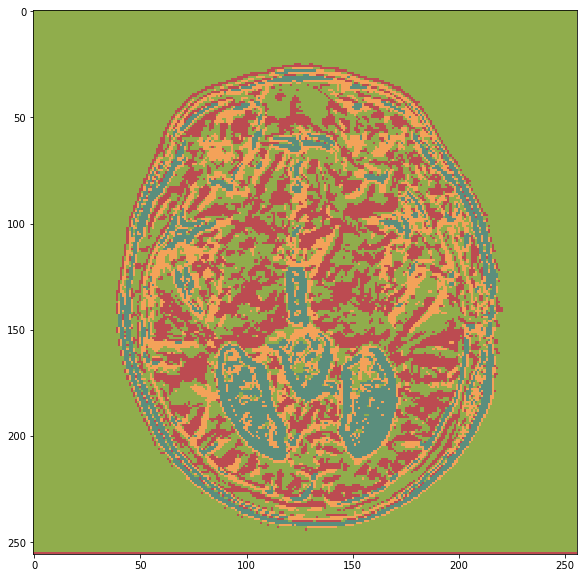

In [12]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

centroids_mean = []
for i in range (0, k):
    centroids_mean.append( mean(final_centroids[0][i]) )


myNumber1 = mean([193.0, 0.0, 62.0])
myNumber2 = mean([194.0, 0.0, 226.0])


def closest(list, Number):
    aux = []
    for valor in list:
        aux.append(abs(Number-valor))

    return aux.index(min(aux))


# Convert a numpy array to an image and display

width, height, r = imagen.shape
data = np.zeros((height, width, 3), dtype=np.uint8)
 

#-------------------------------------------
for i in range(0,width): 
    for j in range(0,height):
        case = closest( centroids_mean, mean([imagencv2[i][j], sobelImage[i][j], lbpImage[i][j]]))
        if case==0:         # Rojo
            data[i][j][0] = 188 
            data[i][j][1] = 75
            data[i][j][2] = 81
        if case==1:         # Verde gris
            data[i][j][0] = 91
            data[i][j][1] = 142
            data[i][j][2] = 125
        if case==2:         # Naranja    
            data[i][j][0] = 244
            data[i][j][1] = 162
            data[i][j][2] = 89
        if case==3:         # Verde    
            data[i][j][0] = 144
            data[i][j][1] = 173
            data[i][j][2] = 76
        if case==4:         # Azul
            data[i][j][0] = 244
            data[i][j][1] = 226
            data[i][j][2] = 133
 
#-------------------------------------------

plt.imshow(data)
plt.show()
